In [333]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
import random

In [334]:
def si_model_updated(G, initial_infected, steps, step_size):
    random.seed(42)
    """
    SI model with dynamic probabilities using edge probabilities and cumulative interactions.

    Parameters:
    G: networkx.Graph
        The multilayer graph with 'probability' attributes on edges.
    initial_infected: list
        List of initially infected nodes.
    steps: int
        Number of time steps.
    step_size: int
        Number of days per step (e.g., 30 days = 1 month).

    Returns:
    susceptible_counts, infected_counts: lists
        Counts of susceptible and infected individuals at each time step.
    """
    # Initialize states
    infected = set(initial_infected)
    susceptible = set(G.nodes()) - infected

    # Track counts
    susceptible_counts = [len(susceptible)]
    infected_counts = [len(infected)]

    # Interaction rates per day (for dynamic calculation)
    per_day = 1

    for step in range(steps):
        # Calculate cumulative interaction multipliers
        per_stepsize = step_size * per_day

        # Dynamic probabilities for the current time step
        new_infected = set()

        for node in infected:
            for neighbor in G.neighbors(node):
                if neighbor in susceptible:
                    # Get edge data
                    edge_data = G.get_edge_data(node, neighbor)
                    base_probability = edge_data.get('probability', 0)  # Use edge 'probability'

                    # Adjust probability based on interaction type
                    dynamic_beta = 1 - (1 - base_probability) ** per_stepsize

                    # Infection attempt
                    if np.random.rand() < dynamic_beta:
                        new_infected.add(neighbor)

        # Update states
        infected |= new_infected
        susceptible -= new_infected

        # Track counts
        susceptible_counts.append(len(susceptible))
        infected_counts.append(len(infected))

    # Normalize
    total_population = len(G.nodes())
    susceptible_counts = [(count / total_population) * 100 for count in susceptible_counts]
    infected_counts = [(count / total_population) * 100 for count in infected_counts]

    return susceptible_counts, infected_counts

In [335]:
G_no1 = nx.read_graphml("G_no1.graphml")
G_no2 = nx.read_graphml("G_no2.graphml")
G_no3 = nx.read_graphml("G_no3.graphml")
G_no4 = nx.read_graphml("G_no4.graphml")
B = nx.read_graphml("B.graphml") 

# SI With Excluding Tie-Types

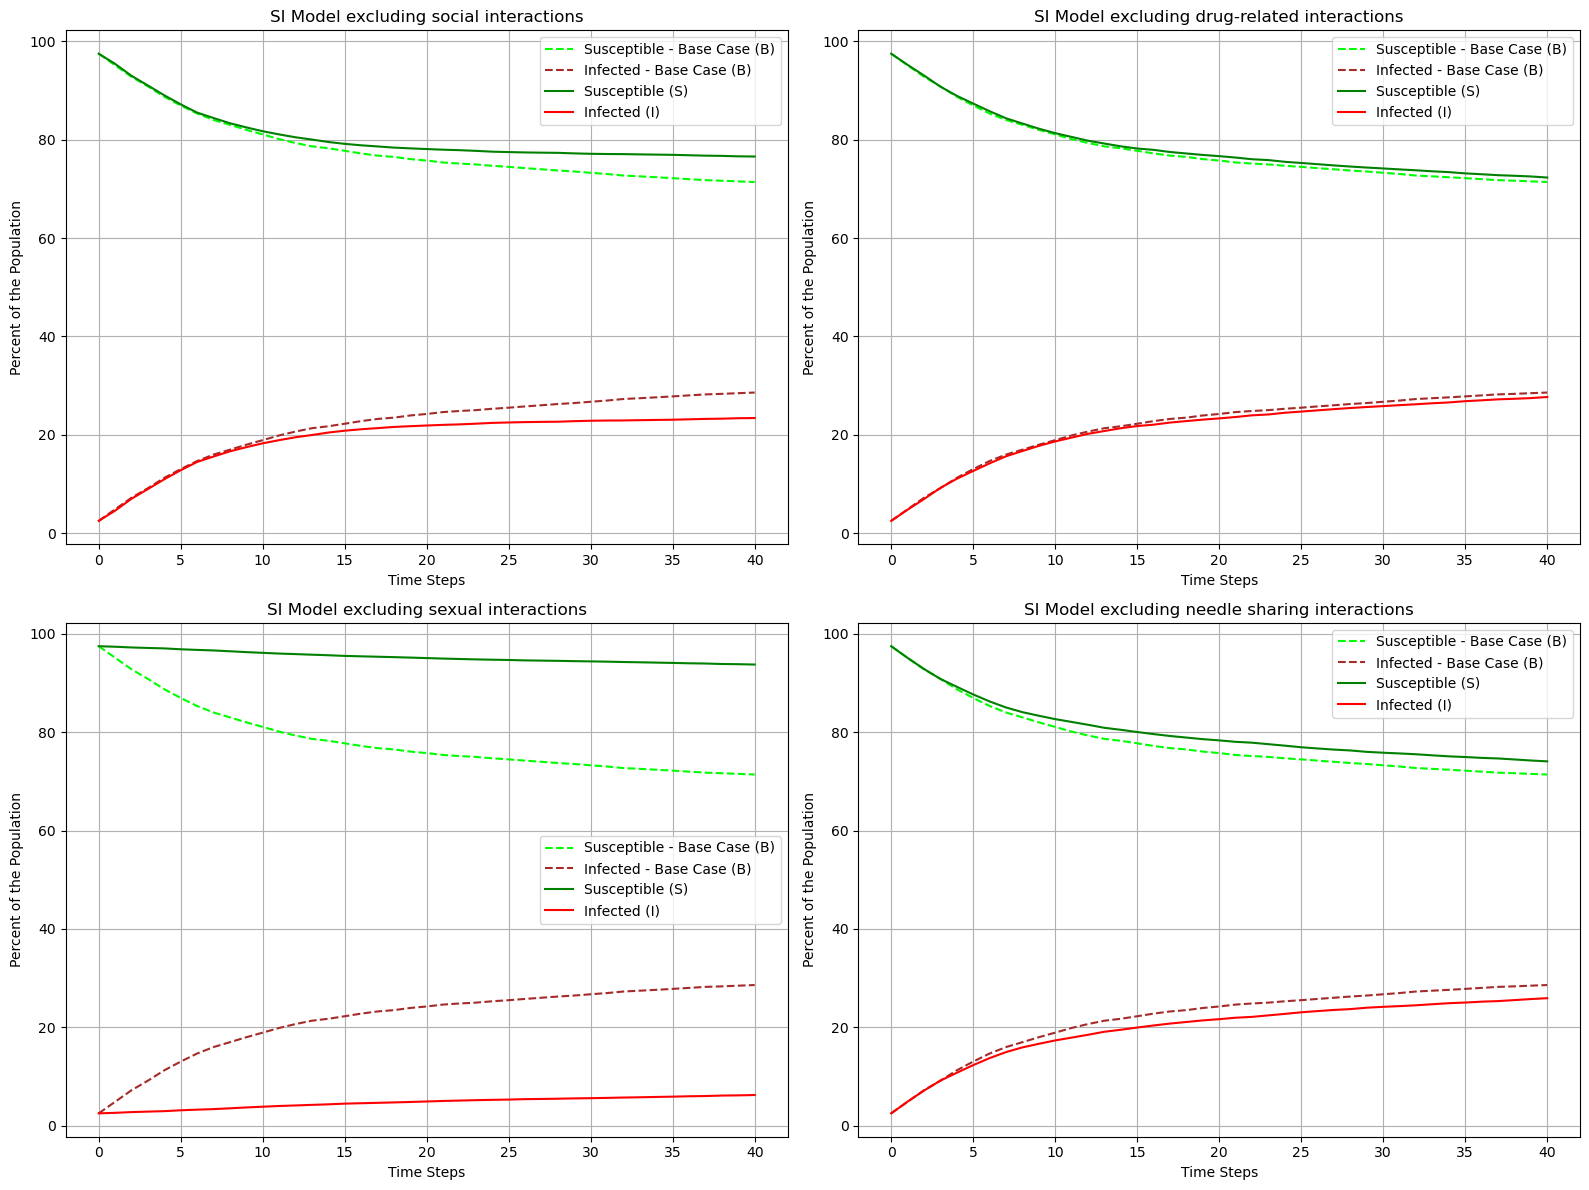

In [336]:
# Base case graph `B` for comparison
initial_infected_B = [
    node for node, attrs in B.nodes(data=True)
    if attrs.get('HIV_status', '').lower() == 'positive'
]

# Parameters
steps = 40
step_size = 30  # 1 month = 30 days

# Run SI model for the base case
susceptible_counts_base, infected_counts_base = si_model_updated(B, initial_infected_B, steps, step_size)

# Your predefined graphs
networks = [G_no1, G_no2, G_no3, G_no4]
network_titles = ["social", "drug-related", "sexual", "needle sharing"]



# Initialize a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Loop over each network and plot
for i, (G, ax) in enumerate(zip(networks, axes)):
    # Total population size
    total_population = G.number_of_nodes()
    
    # Initial infected nodes
    initial_infected = [
        node for node, attrs in G.nodes(data=True)
        if attrs.get('HIV_status', '').lower() == 'positive'
    ]
    
    # Run the SI model for the current graph
    susceptible_counts, infected_counts = si_model_updated(
        G, initial_infected, steps, step_size
    )
    
    # Plot base case from `B`
    ax.plot(
        range(steps + 1),
        susceptible_counts_base,
        label="Susceptible - Base Case (B)",
        color="lime",
        linestyle="--",
    )
    ax.plot(
        range(steps + 1),
        infected_counts_base,
        label="Infected - Base Case (B)",
        color="brown",
        linestyle="--",
    )
    
    # Plot current graph results
    ax.plot(range(steps + 1), susceptible_counts, label="Susceptible (S)", color="green")
    ax.plot(range(steps + 1), infected_counts, label="Infected (I)", color="red")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Percent of the Population")
    ax.set_title(f"SI Model excluding {network_titles[i]} interactions")
    ax.legend()
    ax.grid()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


# PrEP Plots


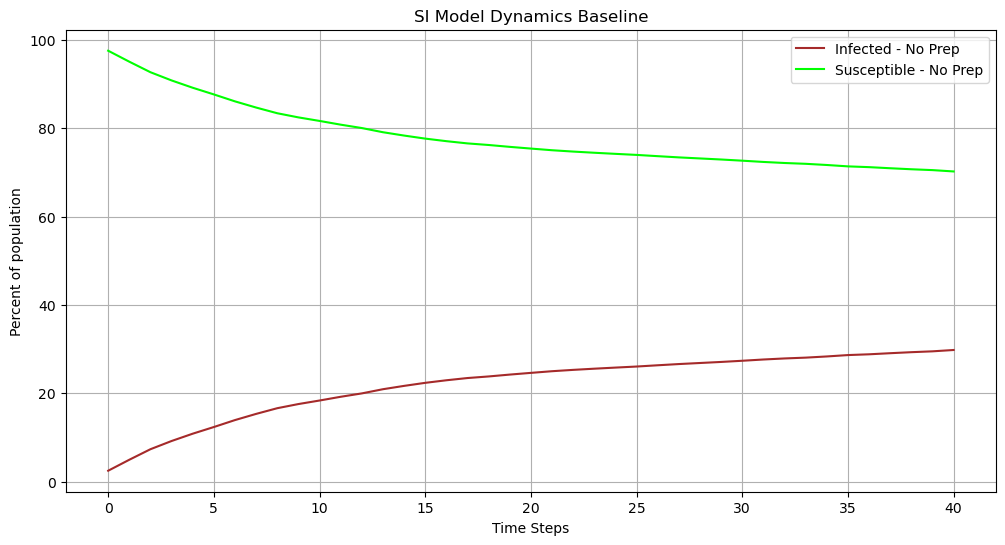

In [337]:
susceptible_counts_no_vax, infected_counts_no_vax = si_model_updated(B, initial_infected, steps, step_size)

# Plot the results (SIV comparison)
plt.figure(figsize=(12, 6))

# No vaccination
plt.plot(
    range(steps + 1),
    infected_counts_no_vax,
    label="Infected - No Prep",
    color="brown",
    linestyle="-",
)
plt.plot(
    range(steps + 1),
    susceptible_counts_no_vax,
    label="Susceptible - No Prep",
    color="lime",
    linestyle="-",
)


plt.xlabel("Time Steps")
plt.ylabel("Percent of population")
plt.title("SI Model Dynamics Baseline")
plt.legend()
plt.grid()
plt.show()

## High degree


100


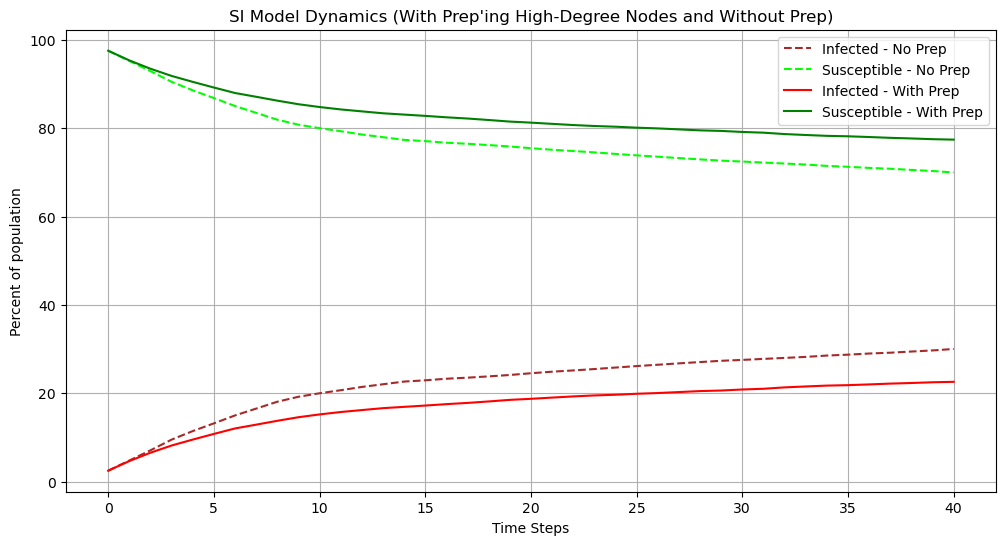

In [338]:
non_infected_node_degrees = {node: B.degree(node) for node in B.nodes() if node not in initial_infected}
sorted_non_infected_node_degrees = sorted(non_infected_node_degrees.items(), key=lambda x: x[1], reverse=True)

# top_N = int(len(non_infected_node_degrees)*0.01) # Adjust this value as needed
top_N = 100
print(top_N)


prep_nodes = [node for node, _ in sorted_non_infected_node_degrees[:top_N]]

# Prep the selected nodes (set edge probabilities to 0 for their connections)
B_prep = B.copy() 
for node in prep_nodes:
    for neighbor in list(B.neighbors(node)):
        B_prep[node][neighbor]["probability"] = 0

#Run the SI model with Prep and without
susceptible_counts_vax_high_degree, infected_counts_vax_high_degree = si_model_updated(B_prep, initial_infected, steps, step_size)
susceptible_counts_no_vax, infected_counts_no_vax = si_model_updated(B, initial_infected, steps, step_size)

# Plot the results (SIV comparison)
plt.figure(figsize=(12, 6))

# No vaccination
plt.plot(
    range(steps + 1),
    infected_counts_no_vax,
    label="Infected - No Prep",
    color="brown",
    linestyle="--",
)
plt.plot(
    range(steps + 1),
    susceptible_counts_no_vax,
    label="Susceptible - No Prep",
    color="lime",
    linestyle="--",
)

# With Prep
plt.plot(
    range(steps + 1),
    infected_counts_vax_high_degree,
    label="Infected - With Prep",
    color="red",
    linestyle="-",
)
plt.plot(
    range(steps + 1),
    susceptible_counts_vax_high_degree,
    label="Susceptible - With Prep",
    color="green",
    linestyle="-",
)

plt.xlabel("Time Steps")
plt.ylabel("Percent of population")
plt.title("SI Model Dynamics (With Prep'ing High-Degree Nodes and Without Prep)")
plt.legend()
plt.grid()
plt.show()

## Random PrEP

Number of not infected:  10605


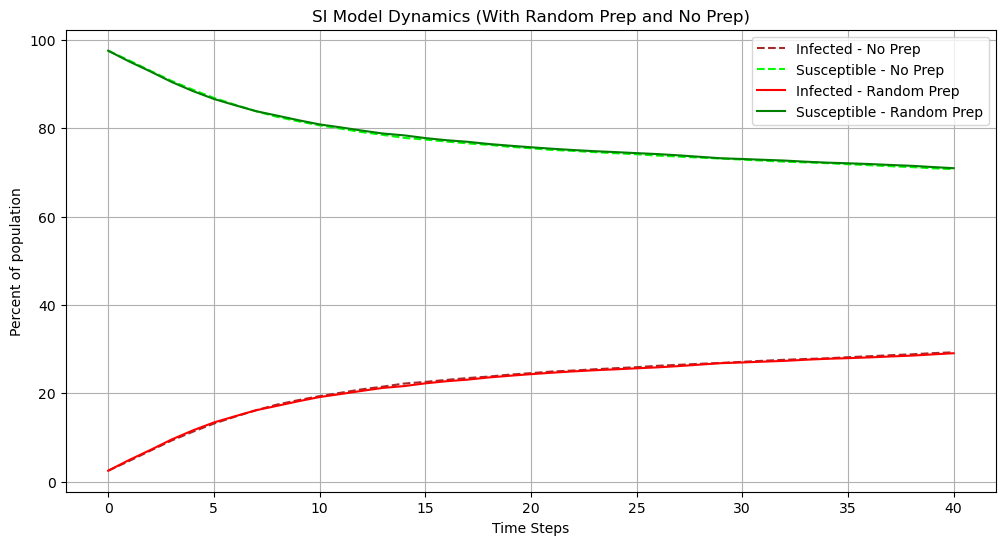

In [389]:
# Step 3: Run the SI model without Prep (original scenario)


susceptible_counts_no_vax, infected_counts_no_vax = si_model_updated(B, initial_infected, steps, step_size)

# Step 4: Randomly vaccinate 25 nodes on a copy of the graph with a fixed seed
random.seed(42)  # Set the seed for reproducibility

non_infected_nodes = [
    node for node, attrs in B.nodes(data=True)
    if attrs.get('HIV_status', '').lower() != 'positive'
]
print("Number of not infected: ", len(non_infected_nodes))
random_prep_nodes = random.sample(non_infected_nodes, top_N)

# Vaccinate the selected nodes (set edge probabilities to 0 for their connections on a copy of the graph)
B_random_prep = B.copy()

for node in random_prep_nodes:
    for neighbor in list(B_random_prep.neighbors(node)):
        B_random_prep[node][neighbor]["probability"] = 0

# Step 5: Run the SI model with random Prep
susceptible_counts_random_vax_random, infected_counts_random_vax_random = si_model_updated(
    B_random_prep, initial_infected, steps, step_size
)

# Step 6: Plot the results (SIV comparison with random Prep)
plt.figure(figsize=(12, 6))

# No Prep
plt.plot(
    range(steps + 1),
    infected_counts_no_vax,
    label="Infected - No Prep",
    color="brown",
    linestyle="--",
)
plt.plot(
    range(steps + 1),
    susceptible_counts_no_vax,
    label="Susceptible - No Prep",
    color="lime",
    linestyle="--",
)

# Random Prep
plt.plot(
    range(steps + 1),
    infected_counts_random_vax_random,
    label="Infected - Random Prep",
    color="red",
    linestyle="-",
)
plt.plot(
    range(steps + 1),
    susceptible_counts_random_vax_random,
    label="Susceptible - Random Prep",
    color="green",
    linestyle="-",
)

plt.xlabel("Time Steps")
plt.ylabel("Percent of population")
plt.title("SI Model Dynamics (With Random Prep and No Prep)")
plt.legend()
plt.grid()
plt.show()

# Output the randomly vaccinated nodes for verification
#print("Randomly Vaccinated Nodes:", random_vaccinated_nodes)

## PrEP Friend

<class 'list'>


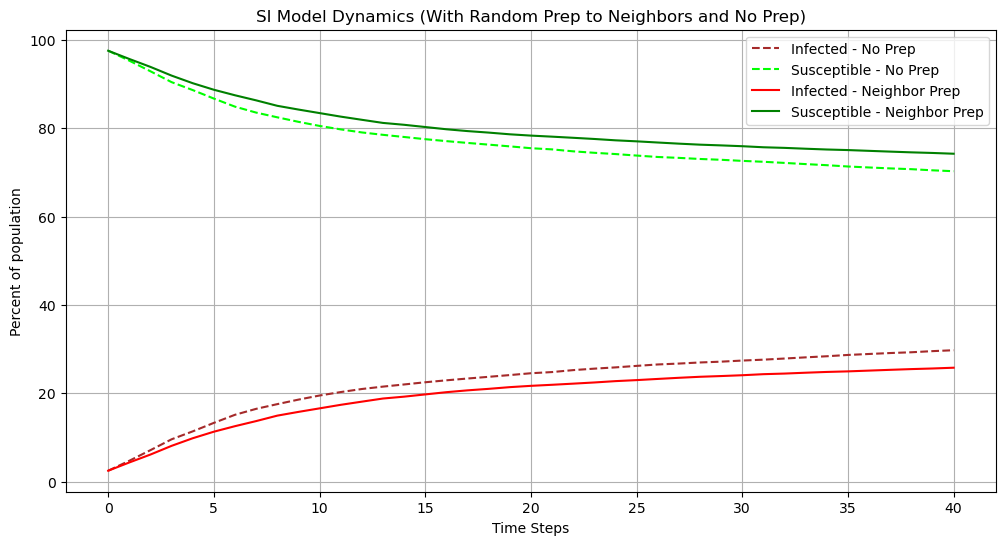

In [340]:
# Step 3: Run the SI model without Prep (original scenario)
susceptible_counts_no_vax, infected_counts_no_vax = si_model_updated(B, initial_infected, steps, step_size)
# Change
# Step 4: Randomly vaccinate 25 nodes on a copy of the graph with a fixed seed
random.seed(42)  # Set the seed for reproducibility

x = list(B.nodes())
random_nodes = random.sample(x, top_N)
neighbors_without_hiv = []
print(type(random_nodes))

for node_id in random_nodes:
    attributes = B.nodes[node_id]
    tmp = []
    neighbors = B.neighbors(node_id)  # Get neighbors of the node

    for neighbor in neighbors:
        if attributes.get('HIV_status') != 'Positive':
            tmp.append(neighbor)  # Process the neighbor as needed
    #print(tmp)
    if len(tmp) == 0:
        continue
    else:
        k = random.sample(tmp, 1)
    neighbors_without_hiv.append(k)

neighbors_without_hiv = [item for sublist in neighbors_without_hiv for item in sublist]

    # Vaccinate the selected nodes (set edge probabilities to 0 for their connections on a copy of the graph)
B_random_neighbors = B.copy()
for node in neighbors_without_hiv:
    for neighbor in list(B_random_neighbors.neighbors(node)):
        B_random_neighbors[node][neighbor]["probability"] = 0

# Step 5: Run the SI model with random Prep
susceptible_counts_vax_random_neighbor, infected_counts_vax_random_neighbor = si_model_updated(
    B_random_neighbors, initial_infected, steps, step_size
)

# Step 6: Plot the results (SIV comparison with random Prep)
plt.figure(figsize=(12, 6))

# No Prep
plt.plot(
    range(steps + 1),
    infected_counts_no_vax,
    label="Infected - No Prep",
    color="brown",
    linestyle="--",
)
plt.plot(
    range(steps + 1),
    susceptible_counts_no_vax,
    label="Susceptible - No Prep",
    color="lime",
    linestyle="--",
)

# Random Prep
plt.plot(
    range(steps + 1),
    infected_counts_vax_random_neighbor,
    label="Infected - Neighbor Prep",
    color="red",
    linestyle="-",
)
plt.plot(
    range(steps + 1),
    susceptible_counts_vax_random_neighbor,
    label="Susceptible - Neighbor Prep",
    color="green",
    linestyle="-",
)

plt.xlabel("Time Steps")
plt.ylabel("Percent of population")
plt.title("SI Model Dynamics (With Random Prep to Neighbors and No Prep)")
plt.legend()
plt.grid()
plt.show()

# Prep to random gay people

100


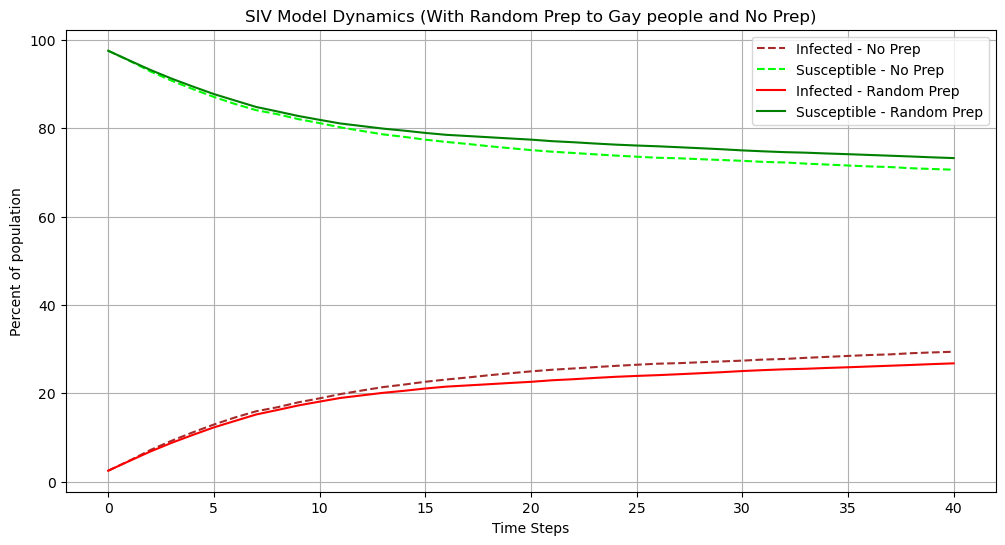

In [409]:
# Step 3: Run the SI model without Prep (original scenario)
susceptible_counts_no_vax, infected_counts_no_vax = si_model_updated(B, initial_infected, steps, step_size)

# Step 4: Randomly vaccinate 25 nodes on a copy of the graph with a fixed seed
random.seed(42)  # Set the seed for reproducibility
gay_people_without_hiv = []
for node_id, attributes in B.nodes(data=True):
    if attributes.get('HIV_status') != 'Positive' and attributes.get('Gay') == 1 and int(attributes.get('Age'))>=15 and int(attributes.get('Age'))<=50:
        gay_people_without_hiv.append(node_id)

random_gay_prep_nodes = random.sample(gay_people_without_hiv, top_N)
print(len(random_gay_prep_nodes))
# Treat the selected nodes (set edge probabilities to 0 for their connections on a copy of the graph)
B_random_prep_gay = B.copy()

for node in random_gay_prep_nodes:
    for neighbor in list(B_random_prep_gay.neighbors(node)):
        B_random_prep_gay[node][neighbor]["probability"] = 0

# Step 5: Run the SI model with random Prep
susceptible_counts_vax_random_gay, infected_counts_vax_random_gay = si_model_updated(
    B_random_prep_gay, initial_infected, steps, step_size
)

# Step 6: Plot the results (SIV comparison with random Prep)
plt.figure(figsize=(12, 6))

# No Prep
plt.plot(
    range(steps + 1),
    infected_counts_no_vax,
    label="Infected - No Prep",
    color="brown",
    linestyle="--",
)
plt.plot(
    range(steps + 1),
    susceptible_counts_no_vax,
    label="Susceptible - No Prep",
    color="lime",
    linestyle="--",
)

# Random Prep
plt.plot(
    range(steps + 1),
    infected_counts_vax_random_gay,
    label="Infected - Random Prep",
    color="red",
    linestyle="-",
)
plt.plot(
    range(steps + 1),
    susceptible_counts_vax_random_gay,
    label="Susceptible - Random Prep",
    color="green",
    linestyle="-",
)

plt.xlabel("Time Steps")
plt.ylabel("Percent of population")
plt.title("SIV Model Dynamics (With Random Prep to Gay people and No Prep)")
plt.legend()
plt.grid()
plt.show()

In [342]:
# Load the .graphml file
file_path = "G_3.graphml"  # Update with the correct path if needed
G = nx.read_graphml(file_path)
len(G.edges)



# Initialize the list to store node IDs with "PRO" in their profession
GAY_PROS = []
PROS=[]
# Iterate over all nodes in the graph
for node_id in G.nodes:
    node_attributes = G.nodes[node_id]
    gaybool=node_attributes.get("Gay", None) 
    HIV_bool=node_attributes.get("HIV_status", None) 
    if gaybool==1 and HIV_bool== 'Negative':
        profession = node_attributes.get("Profession", None)  # Get "Profession"
        
        # Check if the profession attribute exists and contains "PRO"
        if profession and "PRO" in profession.upper():  # Case insensitive check for "PRO"
            GAY_PROS.append(node_id)  # Add the node ID to the list


# Iterate over all nodes in the graph
for node_id in G.nodes:
    node_attributes = G.nodes[node_id]
    HIV_bool=node_attributes.get("HIV_status", None) 
    if HIV_bool== 'Negative':
        profession = node_attributes.get("Profession", None)  # Get "Profession"       
        # Check if the profession attribute exists and contains "PRO"
        if profession and "PRO" in profession.upper():  # Case insensitive check for "PRO"
            PROS.append(node_id)  # Add the node ID to the list


# Print the list of node IDs with "PRO" in their profession
print("Nodes with 'PRO' in their profession:", GAY_PROS)

print(len(GAY_PROS))
print(len(PROS))


Nodes with 'PRO' in their profession: ['283', '337', '618', '2', '77', '10', '493', '259', '765', '258', '290', '175', '26', '25', '564', '694', '720', '728', '389', '860', '938', '86', '557', '640', '388', '144', '764', '871', '846', '237', '169', '248', '193', '495', '238', '4283', '552', '442', '448', '452', '467', '488', '496', '506', '542', '577', '582', '937', '711', '762', '950', '866', '955', '4240', '4247', '4311', '4262', '4287', '4288', '4299']
60
86


404
100
Random gay prep nodes: ['283', '337', '618', '2', '77', '10', '493', '259', '765', '258', '290', '175', '26', '25', '564', '694', '720', '728', '389', '860', '938', '86', '557', '640', '388', '144', '764', '871', '846', '237', '169', '248', '193', '495', '238', '4283', '552', '442', '448', '452', '467', '488', '496', '506', '542', '577', '582', '937', '711', '762', '950', '866', '955', '4240', '4247', '4311', '4262', '4287', '4288', '4299', '4286', '2252', '3930', '4635', '200961', '3129', '12745', '3766', '202362', '4612', '4778', '464', '323', '4781', '13064', '10209', '3191', '2595', '12324', '4154', '12944', '10933', '5728', '2286', '400736', '697', '13307', '202433', '200439', '5339', '1798', '10552', '1064', '100018', '11863', '10460', '202816', '3647', '5478', '1657']
100


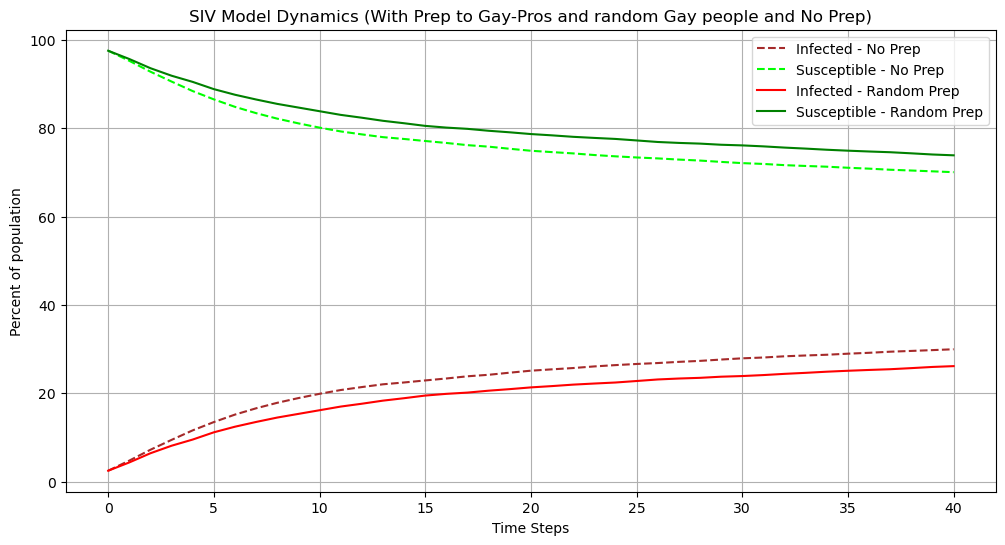

In [404]:
# Step 3: Run the SI model without Prep (original scenario)
susceptible_counts_no_vax, infected_counts_no_vax = si_model_updated(B, initial_infected, steps, step_size)

random.seed(42)  # Set the seed for reproducibility

# Ensure gay_people_without_hiv is a list and starts with GAY_PROS
gay_people_without_hiv = []

# Append additional nodes based on the condition
for node_id, attributes in B.nodes(data=True):
    if attributes.get('HIV_status') != 'Positive' and attributes.get('Gay') == 1 and (int(attributes.get('Age'))>=15 and int(attributes.get('Age'))<=50) :#or int(attributes.get('Age'))>=35 and int(attributes.get('Age'))<=40 ):
        gay_people_without_hiv.append(node_id)

# # Remove the GAY_PROS from gay_people_without_hiv (ensure it is a list)
gay_people_without_hiv = list(set(gay_people_without_hiv) - set(GAY_PROS))
print(len(gay_people_without_hiv))
# # Randomly sample the required number of nodes
random_gay_prep_nodes = GAY_PROS+random.sample(gay_people_without_hiv, top_N - len(GAY_PROS)) 

print(len(random_gay_prep_nodes))

print("Random gay prep nodes:", random_gay_prep_nodes)

print(len(random_gay_prep_nodes))
#Treat the selected nodes (set edge probabilities to 0 for their connections on a copy of the graph)
B_random_prep_gay = B.copy()

for node in random_gay_prep_nodes:
    for neighbor in list(B_random_prep_gay.neighbors(node)):
        B_random_prep_gay[node][neighbor]["probability"] = 0

# Step 5: Run the SI model with random Prep
susceptible_counts_vax_random_gay, infected_counts_vax_random_progay = si_model_updated(
    B_random_prep_gay, initial_infected, steps, step_size
)

# Step 6: Plot the results (SIV comparison with random Prep)
plt.figure(figsize=(12, 6))

# No Prep
plt.plot(
    range(steps + 1),
    infected_counts_no_vax,
    label="Infected - No Prep",
    color="brown",
    linestyle="--",
)
plt.plot(
    range(steps + 1),
    susceptible_counts_no_vax,
    label="Susceptible - No Prep",
    color="lime",
    linestyle="--",
)

# Random Prep
plt.plot(
    range(steps + 1),
    infected_counts_vax_random_progay,
    label="Infected - Random Prep",
    color="red",
    linestyle="-",
)
plt.plot(
    range(steps + 1),
    susceptible_counts_vax_random_gay,
    label="Susceptible - Random Prep",
    color="green",
    linestyle="-",
)

plt.xlabel("Time Steps")
plt.ylabel("Percent of population")
plt.title("SIV Model Dynamics (With Prep to Gay-Pros and random Gay people and No Prep)")
plt.legend()
plt.grid()
plt.show()


# Combined prep plot

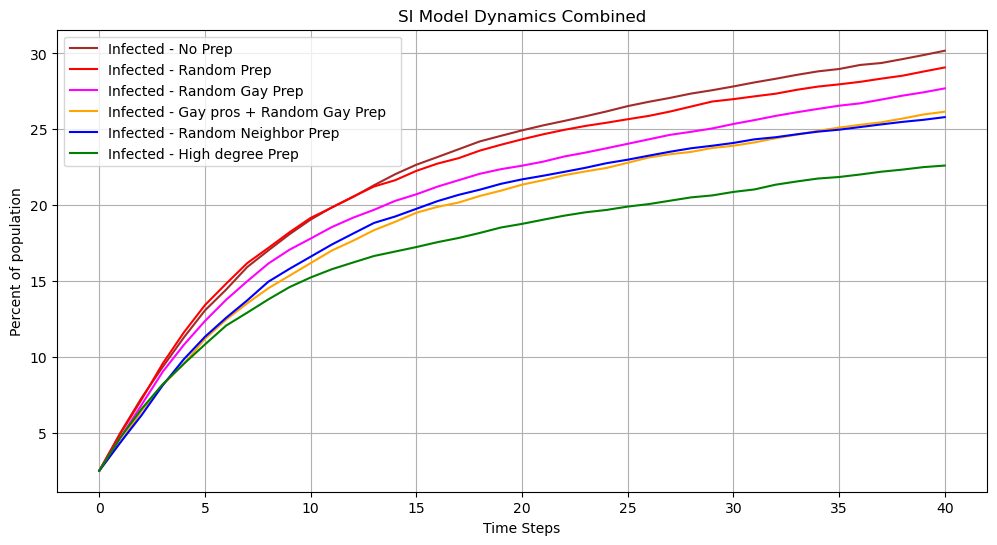

In [405]:
random.seed(42)  
susceptible_counts_no_vax, infected_counts_no_vax = si_model_updated(B, initial_infected, steps, step_size)

plt.figure(figsize=(12, 6))

plt.plot(
    range(steps + 1),
    infected_counts_no_vax,
    label="Infected - No Prep",
    color="brown",
    linestyle="-",
)

plt.plot(
    range(steps + 1),
    infected_counts_random_vax_random,
    label="Infected - Random Prep",
    color="red",
    linestyle="-",
)

plt.plot(
    range(steps + 1),
    infected_counts_vax_random_gay,
    label="Infected - Random Gay Prep",
    color="magenta",
    linestyle="-",
)

plt.plot(
    range(steps + 1),
    infected_counts_vax_random_progay,
    label="Infected - Gay pros + Random Gay Prep  ",
    color="orange",
    linestyle="-",
)

plt.plot(
    range(steps + 1),
    infected_counts_vax_random_neighbor,
    label="Infected - Random Neighbor Prep",
    color="blue",
    linestyle="-",
)

plt.plot(
    range(steps + 1),
    infected_counts_vax_high_degree,
    label="Infected - High degree Prep",
    color="green",
    linestyle="-",
)





plt.xlabel("Time Steps")
plt.ylabel("Percent of population")
plt.title("SI Model Dynamics Combined")
plt.legend()
plt.grid()
plt.show()

# Power Law

Exponent (gamma): 1.9498928831877471
Xmin (minimum degree where power law applies): 1.0
Comparison with exponential: R = 5047.108542120142 , p = 2.5611981333936284e-249


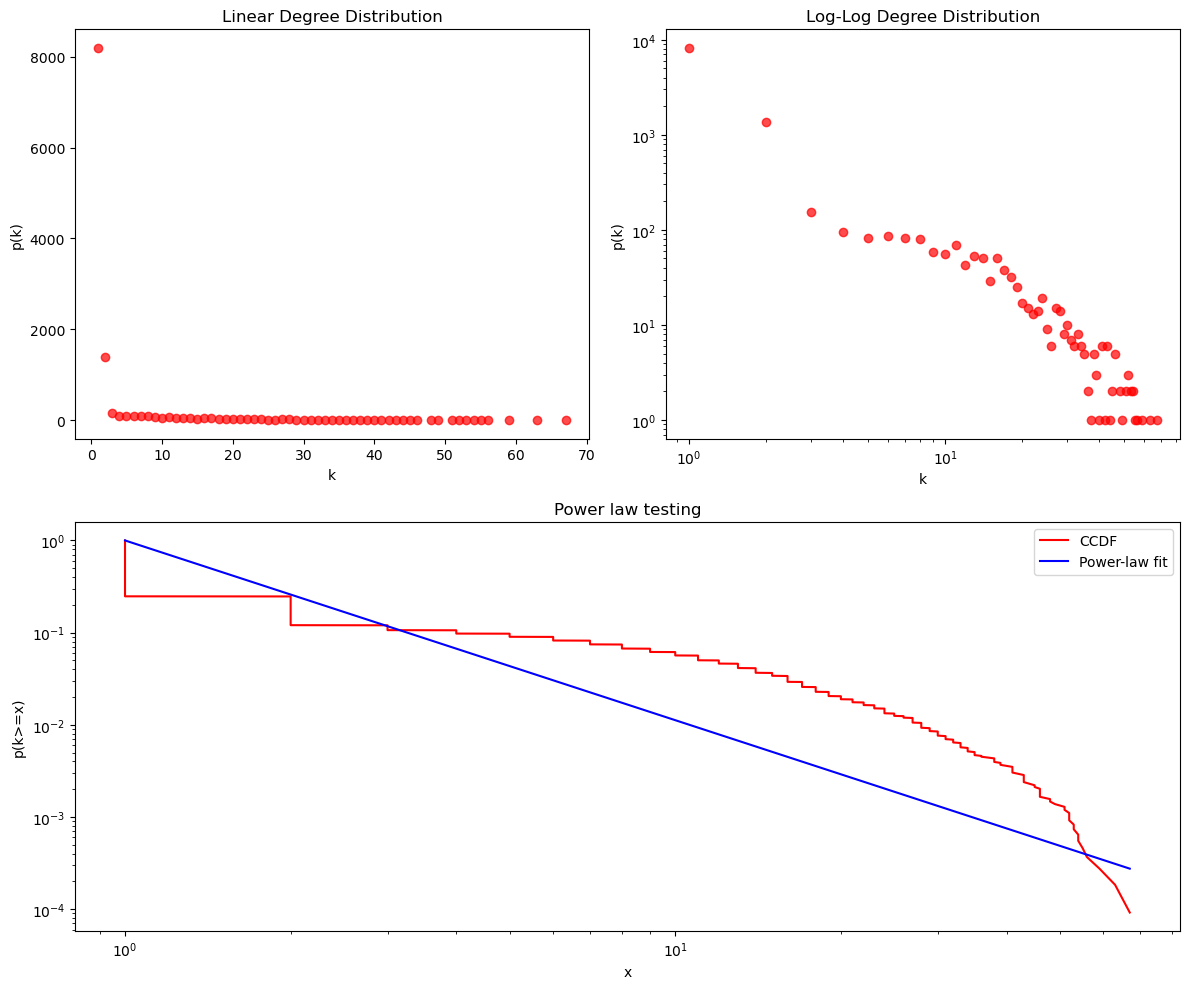

In [345]:
import networkx as nx
import powerlaw
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Load your multilayer network (assuming it's already in a NetworkX format)
full_network = B  # Replace this with your actual graph

# Step 1: Calculate degrees for all nodes
degrees = [degree for _, degree in full_network.degree()]
if not degrees:
    print("No degree data available. Exiting.")
    exit()

# Step 2: Fit the degree distribution to a power-law model
fit = powerlaw.Fit(degrees, xmin=1, discrete=True)

# Print the results
print("Exponent (gamma):", fit.power_law.alpha)
print("Xmin (minimum degree where power law applies):", fit.power_law.xmin)

# Compare fit with alternative distributions
R, p = fit.distribution_compare('power_law', 'exponential')
print("Comparison with exponential: R =", R, ", p =", p)

# Step 3: Plot Degree Distribution (3 Plots)
plt.figure(figsize=(12, 10))

# --- Top Left: Linear Degree Distribution ---
plt.subplot(2, 2, 1)
degree_count = Counter(degrees)
deg, cnt = zip(*sorted(degree_count.items()))
plt.scatter(deg, cnt, color='red', alpha=0.7)
plt.xlabel("k")
plt.ylabel("p(k)")
plt.title("Linear Degree Distribution")

# --- Top Right: Log-Log Degree Distribution ---
plt.subplot(2, 2, 2)
plt.scatter(deg, cnt, color='red', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("k")
plt.ylabel("p(k)")
plt.title("Log-Log Degree Distribution")

# --- Bottom: CCDF Plot ---
plt.subplot(2, 1, 2)
sorted_degrees = sorted(degrees, reverse=True)
ccdf_y = [i / len(sorted_degrees) for i in range(1, len(sorted_degrees) + 1)]
plt.plot(sorted_degrees, ccdf_y, 'r', label='CCDF')
plt.xscale('log')
plt.yscale('log')
plt.plot(sorted_degrees, np.array(sorted_degrees)**-fit.power_law.alpha, 'b', label='Power-law fit')  # Power-law fit line
plt.xlabel("x")
plt.ylabel("p(k>=x)")
plt.title("Power law testing")
plt.legend()

# Show all plots
plt.tight_layout()
plt.show()

# fun 